## MODELS 

- SVC
- KNN

In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,\
                            roc_curve, auc, roc_auc_score, f1_score, precision_recall_curve,\
                            precision_score, average_precision_score, recall_score
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD 
import pickle
from mlxtend.plotting import plot_decision_regions

In [4]:
import warnings
warnings.filterwarnings("ignore")
import scikitplot 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Read preprocessed data that stored in pickles

In [5]:
## vectorization CountVectorizer()
with open('train_data.pkl', 'rb') as f:
      X_tr, y_tr = pickle.load(f)
        
with open('test_data.pkl', 'rb') as f:
      X_te, y_te = pickle.load(f)
        
## vectorization TfidfVectorizer()
with open('train_data2.pkl', 'rb') as f:
      X_tr2, y_tr2 = pickle.load(f)
        
with open('test_data2.pkl', 'rb') as f:
      X_te2, y_te2 = pickle.load(f)

## SVC and KNN

In [6]:
## function to turn parameters for SVC
def svc_tune_parameter(X, y, metric, kernel_set, C_set, cv):
    
    """ Tune parameters for SVC classifier.
    Parameters:
        X(array-like, sparse matrix): Training set
        y(array-like):labels 
        metric(dict): Evaluation metrics
        kernel_set(list): Different kernel tricks for tuning
        C_set(list): Penalty parameter C of the error term
        cv(int): k-folds of cross validation
    
    Return: 
        S(dict): scores for different tuning parameters
    """
    
    S = {}
    for k in kernel_set:
        score = {}
        for c in C_set:
            model = SVC(C = c, kernel = k)
            s = model_selection.cross_validate(model, X, y, scoring = metric, cv = cv)
            score[c] = s
        S[k] = score
    return S

In [7]:
## function for tuning parameters for KNN
def knn_tune_parameter(X, y, metric, Weight, N_neighbors, cv):
    
    """ Tune parameters for KNN classifier.
    
    Parameters:
        X(array-like, sparse matrix): Training set
        y(array-like):labels 
        metric(dict): Evaluation metrics
        Weight(list): Different weight methods for tuning
        N_neighbors(list): Number of K nearest neighbors
        cv(int): k-folds of cross validation
    
    Return: 
        S(dict): scores for different tuning parameters
    """
    
    S = {}
    for w in Weight:
        score = {}
        for n in N_neighbors:
            model = KNeighborsClassifier(n_neighbors = n, weights = w)
            s = model_selection.cross_validate(model, X, y, scoring = metric, cv = cv)
            score[n] = s
        S[w] = score
    return S


In [8]:
##return the mean score for 5-fold cross-validation with given metric
def mean_calculator(metric, kernel, C, S_dict):
    
    """ Calculate mean score for cross validation
    
    Parameters:
        metric(str): Evaluation metric
        kernel(list): Tuning parameter 
        C(list): Tuning parameter
        s_dict: Scores for different tuning parameters
        
    Return:
        (int): Mean score for cross validation.
    
    """
    return(np.mean(S_dict[kernel][C][metric]))

In [9]:
##calculate the max score with given metric, crossing kernel and C
def best_parameter(metric, kernel, C, S_dict):
        
    """ Calculate best score for best model.
    
    Parameters:
        metric(str): Evaluation metric
        kernel(list): Tuning parameter 
        C(list): Tuning parameter
        s_dict: Scores for different tuning parameters
        
    Return:
        (dict): Max score with given metric, crossing kernel and C
    
    """
    
    M = {}
    for k in kernel:
        mid = {}
        for c in C:
            mean = mean_calculator(metric, k, c, S_dict)
            mid[c] = mean
        M[k] = mid
        
    max_c_kernel = {}
    for k in kernel:
        max_c_kernel[k] = max(M[k].items(), key = lambda x: x[1])
    
    
    max_kernel = max(max_c_kernel.items(), key = lambda x: x[1][1])
        
    return (max_kernel, max_c_kernel, M)

In [10]:
def report_best_model(results):
    """Report BEST model
    
    Parameters:
        results(dic): All results for cross validation
    Return:
        best model
    """ 
    best_para = results[0]
    print('Best parameters are:', best_para)

In [11]:
def report_results1(results,para1,para2):
    """Report best results for parameter1
    
    Parameters:
        results(dict):All results for cross validation
        para1(str): Tuning parameters
        para2(str): Tuning parameters
        
    Returns:
        df1(dataframe):report best results for parameter1
    """
    # best paramerts for different parameter
    a = [[k,list(v)] for k,v in results[1].items()]
    a = [[l[0], l[1][0], l[1][1]] for l in a]
    df1 = pd.DataFrame(a,columns = [para1,para2,'F1_score'])
        
    return df1

In [12]:
def report_results2(results,para1,para2):
    """Report best results for parameter1
    
    Parameters:
        results(dict):All results for cross validation
        para1(str): Tuning parameters
        para2(str): Tuning parameters
        
    Returns:
        df2(dataframe):Report best results for parameter1 and parameters
    """
# best scores for different parameter 1 and parameter 2
    b = results[2]
    df2 = pd.DataFrame()
    for i in b.keys():
        temp = pd.DataFrame.from_dict(b[i],orient='index',columns = [i])
        df2 = pd.concat((df2,temp),axis = 1)
    return df2

### Model Selection  For CountVectorizer

In [13]:
#specify metric list output for 5-fold cross validation
#choose to use test f1 score to compare each combinations of parameters of model
metric = {'Accuracy': make_scorer(accuracy_score), \
                     'precision': make_scorer(precision_score), \
                     'recall': make_scorer(recall_score), \
                     'AUC': make_scorer(roc_auc_score), \
                     'precision-recall curve' : make_scorer(average_precision_score),\
                     'f1' : make_scorer(f1_score)}

metric_used = 'test_f1'

#parameter set to tune
# for SVC, tune kernel list and penalty C parameters
kernel_set = ['linear', 'rbf', 'poly', 'sigmoid']
C_set = range(1,6)
Weights = ['uniform', 'distance']
N_neighbors = range(5,16)

In [14]:
#tuning parameters for SVC and KNN with CountVectorizer()
s = svc_tune_parameter(X_tr, y_tr, metric, kernel_set, C_set, cv = 5)
s2 = knn_tune_parameter(X_tr, y_tr, metric, Weights, N_neighbors, cv = 5)

In [15]:
# compare acrocss each parameters combinations using the mean score of 5-fold crossvalidation
compare_result = best_parameter(metric_used, kernel_set, C_set, s)

#### cross validation results for SVM(CountVectorizer)

In [16]:
# report best model
report_best_model(compare_result)

Best parameters are: ('linear', (1, 0.9210145452992332))


In [17]:
report_results1(compare_result,"kenerl",'C')

,kenerl,C,F1_score
0,linear,1,0.921015
1,rbf,1,0.000000
2,poly,1,0.000000
3,sigmoid,1,0.000000


In [18]:
report_results2(compare_result,"kenerl",'C')

,linear,rbf,poly,sigmoid
1,0.921015,0.0,0.0,0.0
2,0.920107,0.0,0.0,0.0
3,0.920107,0.0,0.0,0.0
4,0.920107,0.0,0.0,0.0
5,0.920107,0.0,0.0,0.0


#### cross validation results for KNN(CountVectorizer)

In [19]:
compare_result2 = best_parameter(metric_used, Weights, N_neighbors, s2)

In [20]:
report_best_model(compare_result2)

Best parameters are: ('distance', (5, 0.6573199837911192))


In [21]:
report_results1(compare_result2,"Weights",'N_neighbors')

,Weights,N_neighbors,F1_score
0,uniform,5,0.478248
1,distance,5,0.657320


In [22]:
report_results2(compare_result2,"Weights",'N_neighbors')

,uniform,distance
5,0.478248,0.657320
6,0.362987,0.634389
7,0.381086,0.611692
8,0.292579,0.584416
9,0.294840,0.567174
10,0.191763,0.537632
11,0.194472,0.517309
12,0.142040,0.492708
13,0.147437,0.472931
14,0.122873,0.460070


### Model Selection For TfidfVectorizer

In [23]:
s3 = svc_tune_parameter(X_tr2, y_tr2, metric, kernel_set, C_set, cv = 5)
s4 = knn_tune_parameter(X_tr2, y_tr2, metric, Weights, N_neighbors, cv = 5)

In [24]:
compare_result3 = best_parameter(metric_used, kernel_set, C_set, s3)

#### cross validation results for SVM(TfidfVectorizer)

In [25]:
report_best_model(compare_result3)

Best parameters are: ('linear', (2, 0.919462361926137))


In [26]:
report_results1(compare_result3,"kenerl",'C')

,kenerl,C,F1_score
0,linear,2,0.919462
1,rbf,1,0.000000
2,poly,1,0.000000
3,sigmoid,1,0.000000


In [27]:
report_results2(compare_result3,"kenerl",'C')

,linear,rbf,poly,sigmoid
1,0.911962,0.0,0.0,0.0
2,0.919462,0.0,0.0,0.0
3,0.916730,0.0,0.0,0.0
4,0.915048,0.0,0.0,0.0
5,0.914134,0.0,0.0,0.0


#### cross validation results for KNN(TfidfVectorizer)

In [28]:
compare_result4 = best_parameter(metric_used, Weights, N_neighbors, s4)

In [29]:
report_best_model(compare_result4)

Best parameters are: ('distance', (15, 0.7087592180827418))


In [30]:
report_results1(compare_result4,"Weight",'N_neighbors')

,Weight,N_neighbors,F1_score
0,uniform,15,0.627227
1,distance,15,0.708759


In [31]:
report_results2(compare_result4,"Weight",'N_neighbors')

,uniform,distance
5,0.456013,0.635045
6,0.361404,0.617706
7,0.369426,0.595392
8,0.281113,0.575599
9,0.291622,0.574205
10,0.226755,0.607130
11,0.442399,0.644259
12,0.400074,0.659664
13,0.595894,0.681316
14,0.568874,0.702779


## Best model selected as below: 
- CountVectorizer(): 
    - Best model of SVC is linear with c = 1
    - Best model of KNN is distance with n = 5


- TfidfVectorizer() 
    - Best model of SVC is lienar with c = 2
    - Best model of KNN is distance with n = 15

## Model Evaluation

In [32]:
M1 = SVC(C = 1, kernel = 'linear', probability = True)
M2 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
M3 = SVC(C = 2, kernel = 'linear', probability = True)
M4 = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')

In [33]:
def plot_roc(model,plot_title, x_tr, y_tr, x_te,y_te):
    probas_= model.fit(x_tr, y_tr).predict_proba(x_te)
    print("roc_auc for class 1:", metrics.roc_auc_score(y_te,probas_[:,1]))
    scikitplot.metrics.plot_roc(y_te, probas_, 
                            title = plot_title,
                            plot_micro = False, plot_macro = False)
    plt.show()

In [34]:
def plot_precision(model,plot_title, x_tr, y_tr,x_te, y_te):
    probas_= model.fit(x_tr, y_tr).predict_proba(x_te)
    scikitplot.metrics.plot_precision_recall(y_te, probas_, 
                                         title = plot_title,
                                         plot_micro = False)
    
                          
    plt.show()

#### model = M1, CountVectorizer(), SVC is linear with c = 1

In [61]:
M1 = M1.fit(X_tr, y_tr)
pre = M1.predict(X_te)
pd.DataFrame(confusion_matrix(pre, y_te),\
             index = ['Predict ham', 'Predict spam'], \
             columns = ['Actual ham', 'Actual spam'])

,Actual ham,Actual spam
Predict ham,726,17
Predict spam,2,91


In [62]:
print(classification_report(pre, y_te))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       743
           1       0.84      0.98      0.91        93

    accuracy                           0.98       836
   macro avg       0.92      0.98      0.95       836
weighted avg       0.98      0.98      0.98       836



roc_auc for class 1: 0.9920634920634921


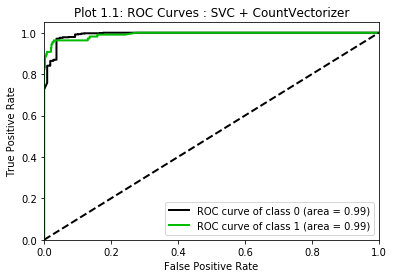

In [63]:
plot_roc(M1,"Plot 1.1: ROC Curves : SVC + CountVectorizer", X_tr,y_tr, X_te, y_te)

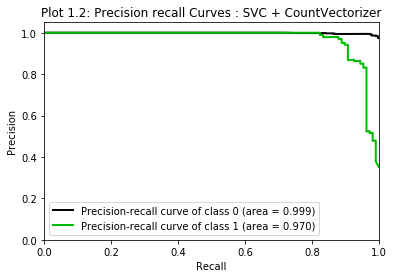

In [64]:
plot_precision(M1,"Plot 1.2: Precision recall Curves : SVC + CountVectorizer",X_tr,y_tr, X_te, y_te)

#### model = M2, CountVectorizer(), KNN is distance with n = 5

In [65]:
M2 = M2.fit(X_tr, y_tr)
pre2 = M2.predict(X_te)
pd.DataFrame(confusion_matrix(pre2, y_te),\
             index = ['Predict ham', 'Predict spam'], \
             columns = ['Actual ham', 'Actual spam'])

,Actual ham,Actual spam
Predict ham,728,44
Predict spam,0,64


In [66]:
print(classification_report(pre2, y_te))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       772
           1       0.59      1.00      0.74        64

    accuracy                           0.95       836
   macro avg       0.80      0.97      0.86       836
weighted avg       0.97      0.95      0.95       836



roc_auc for class 1: 0.8472222222222222


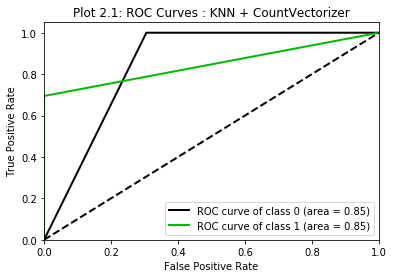

In [67]:
plot_roc(M2,"Plot 2.1: ROC Curves : KNN + CountVectorizer",X_tr,y_tr, X_te, y_te)

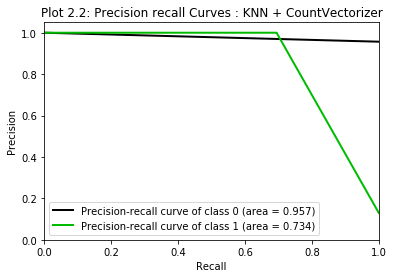

In [68]:
plot_precision(M2,"Plot 2.2: Precision recall Curves : KNN + CountVectorizer",X_tr,y_tr, X_te, y_te)

#### model = M3, TfidfVectorizer(), SVC is linear with c = 2

In [69]:
M3 = M3.fit(X_tr2, y_tr2)
pre3 = M3.predict(X_te2)
pd.DataFrame(confusion_matrix(pre3, y_te2),\
             index = ['Predict ham', 'Predict spam'], \
             columns = ['Actual ham', 'Actual spam'])

,Actual ham,Actual spam
Predict ham,725,14
Predict spam,3,94


In [70]:
print(classification_report(pre3, y_te2))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       739
           1       0.87      0.97      0.92        97

    accuracy                           0.98       836
   macro avg       0.93      0.98      0.95       836
weighted avg       0.98      0.98      0.98       836



roc_auc for class 1: 0.9950206043956045


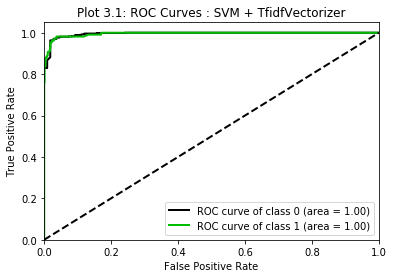

In [71]:
plot_roc(M3,"Plot 3.1: ROC Curves : SVM + TfidfVectorizer",X_tr2,y_tr2, X_te2, y_te2)

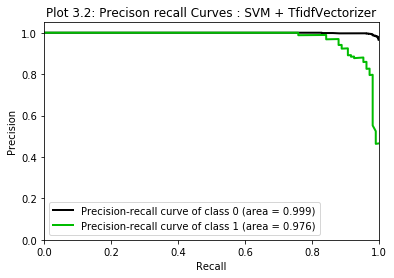

In [72]:
plot_precision(M3, "Plot 3.2: Precison recall Curves : SVM + TfidfVectorizer",X_tr2,y_tr2, X_te2, y_te2)

#### model = M4, TfidfVectorizer(), KNN is distance with n = 15

In [73]:
M4 = M4.fit(X_tr2, y_tr2)
pre4 = M4.predict(X_te2)
pd.DataFrame(confusion_matrix(pre4, y_te2),\
             index = ['Predict ham', 'Predict spam'], \
             columns = ['Actual ham', 'Actual spam'])

,Actual ham,Actual spam
Predict ham,728,40
Predict spam,0,68


In [74]:
print(classification_report(pre4, y_te2))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       768
           1       0.63      1.00      0.77        68

    accuracy                           0.95       836
   macro avg       0.81      0.97      0.87       836
weighted avg       0.97      0.95      0.96       836



roc_auc for class 1: 0.9866452991452991


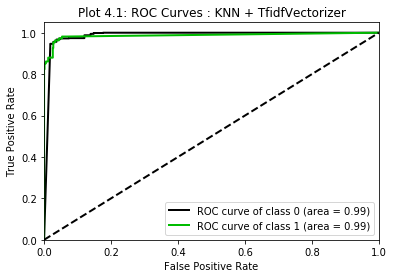

In [75]:
plot_roc(M4,"Plot 4.1: ROC Curves : KNN + TfidfVectorizer",X_tr2,y_tr2, X_te2, y_te2)

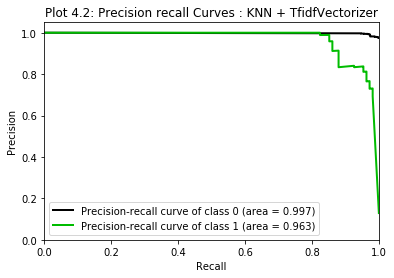

In [76]:
plot_precision(M4, "Plot 4.2: Precision recall Curves : KNN + TfidfVectorizer",X_tr2,y_tr2, X_te2, y_te2)

### Store models

In [77]:
## store four models
with open('svc_model/svc_count.pkl','wb') as f:
    pickle.dump((M1), f)
    
with open('knn_model/knn_count.pkl','wb') as f:
    pickle.dump((M2), f)

with open('svc_model/svc_tfid.pkl','wb') as f:
    pickle.dump((M3), f)
    
with open('knn_model/knn_tfid.pkl','wb') as f:
    pickle.dump((M4), f)

### PCA to visualize decision regions for reduced dimension data

In [78]:
#run pca on data to filter and get 2 frist principal components
#to train the model with the 2 frist principal components to plot decision regions
n = np.arange(0, X_tr.shape[0], 1)

pca = TruncatedSVD(n_components=2)
X_tr_reduced = pca.fit_transform(X_tr[n])

In [79]:
# train SVC with 4 different kernel and C = 1 with reduced training data
M5 = LinearSVC(C = 5)
M5.fit(X_tr_reduced, np.array(y_tr)[n])

M6 = SVC(kernel = 'poly', C = 1)
M6.fit(X_tr_reduced, np.array(y_tr)[n])

M7 = SVC(kernel = 'rbf', C = 1)
M7.fit(X_tr_reduced, np.array(y_tr)[n])

M8 = SVC(kernel = 'sigmoid', C = 1)
M8.fit(X_tr_reduced, np.array(y_tr)[n])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

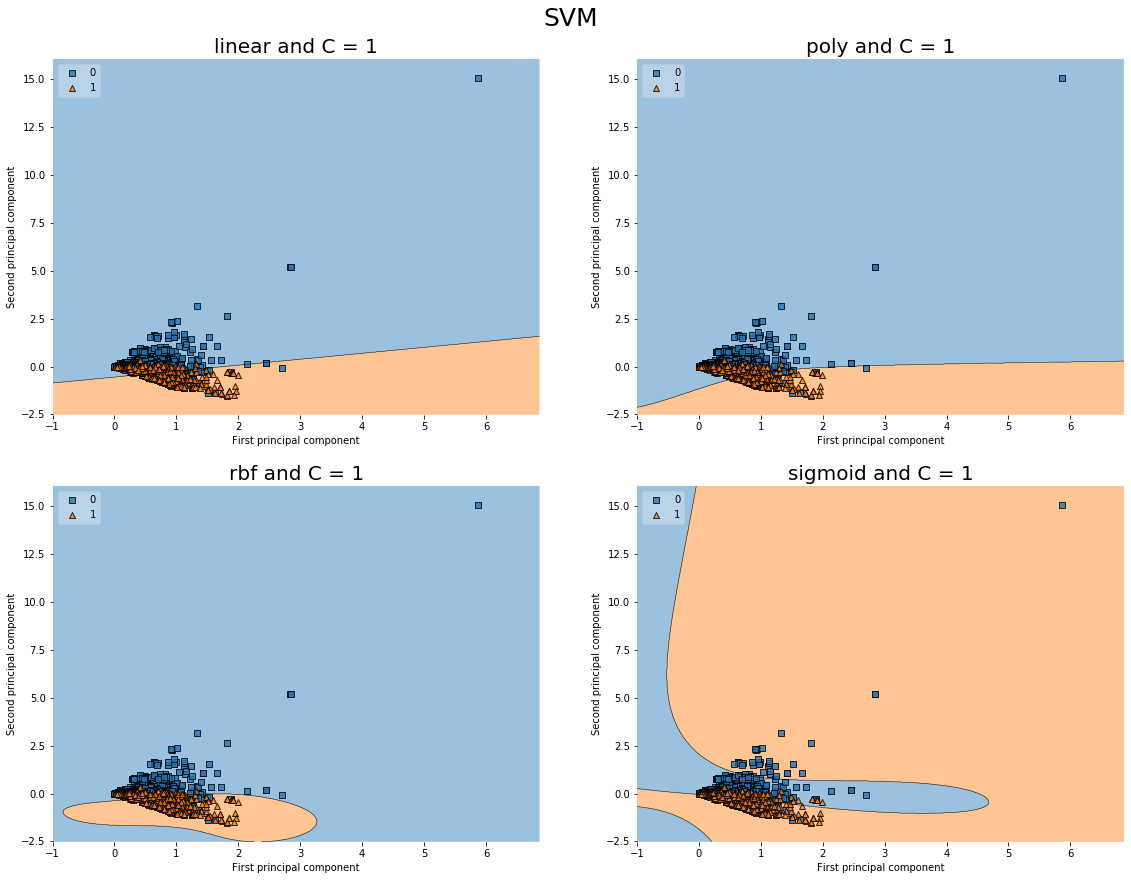

In [80]:
#plot 4 plots of decision regions
fig = plt.figure(figsize = [6.4*3, 4.8*3])

plt.suptitle('SVM', fontsize=25, y = 0.93)

plt.subplot(2, 2, 1)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M5, legend=2)
plt.title('linear and C = 1', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 2)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M6, legend=2)
plt.title('poly and C = 1', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 3)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M7, legend=2)
plt.title('rbf and C = 1', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 4)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M8, legend=2)
plt.title('sigmoid and C = 1', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()
fig.savefig('pca_SVM_c1.png')

In [81]:
# train SVC with 4 different kernel and C = 10 with reduced training data
M9 = LinearSVC(C = 5)
M9.fit(X_tr_reduced, np.array(y_tr)[n])

M10 = SVC(kernel = 'poly', C = 10)
M10.fit(X_tr_reduced, np.array(y_tr)[n])

M11 = SVC(kernel = 'rbf', C = 10)
M11.fit(X_tr_reduced, np.array(y_tr)[n])

M12 = SVC(kernel = 'sigmoid', C = 10)
M12.fit(X_tr_reduced, np.array(y_tr)[n])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

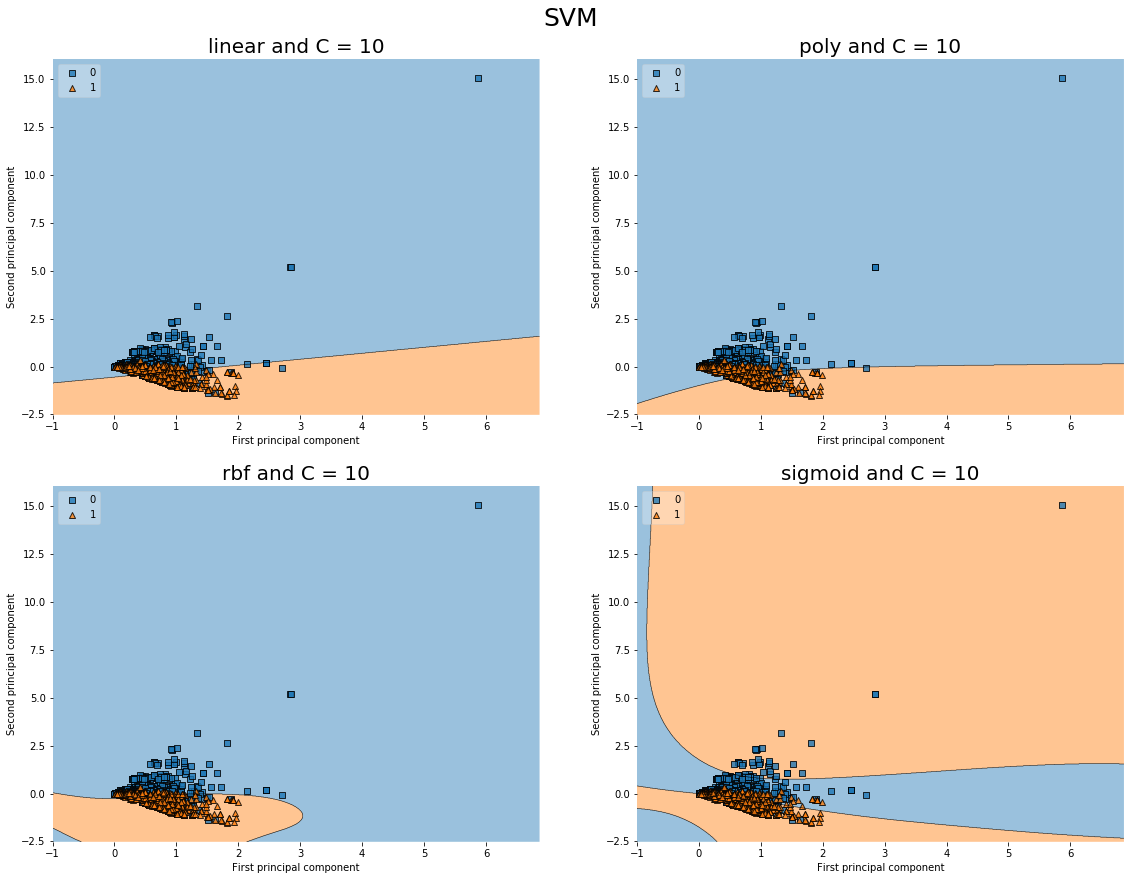

In [82]:
#plot 4 plots of decision regions
fig = plt.figure(figsize = [6.4*3, 4.8*3])

plt.suptitle('SVM', fontsize=25, y = 0.93)

plt.subplot(2, 2, 1)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M9, legend=2)
plt.title('linear and C = 10', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 2)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M10, legend=2)
plt.title('poly and C = 10', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 3)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M11, legend=2)
plt.title('rbf and C = 10', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 4)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M12, legend=2)
plt.title('sigmoid and C = 10', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

fig.savefig('pca_SVM_c10.png')

In [83]:
# train SVC with 4 different weight functions and k = 5 and 15 with reduced training data
M13 = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
M13.fit(X_tr_reduced, np.array(y_tr)[n])

M14 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
M14.fit(X_tr_reduced, np.array(y_tr)[n])

M15 = KNeighborsClassifier(n_neighbors = 15, weights = 'uniform')
M15.fit(X_tr_reduced, np.array(y_tr)[n])

M16 = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
M16.fit(X_tr_reduced, np.array(y_tr)[n])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

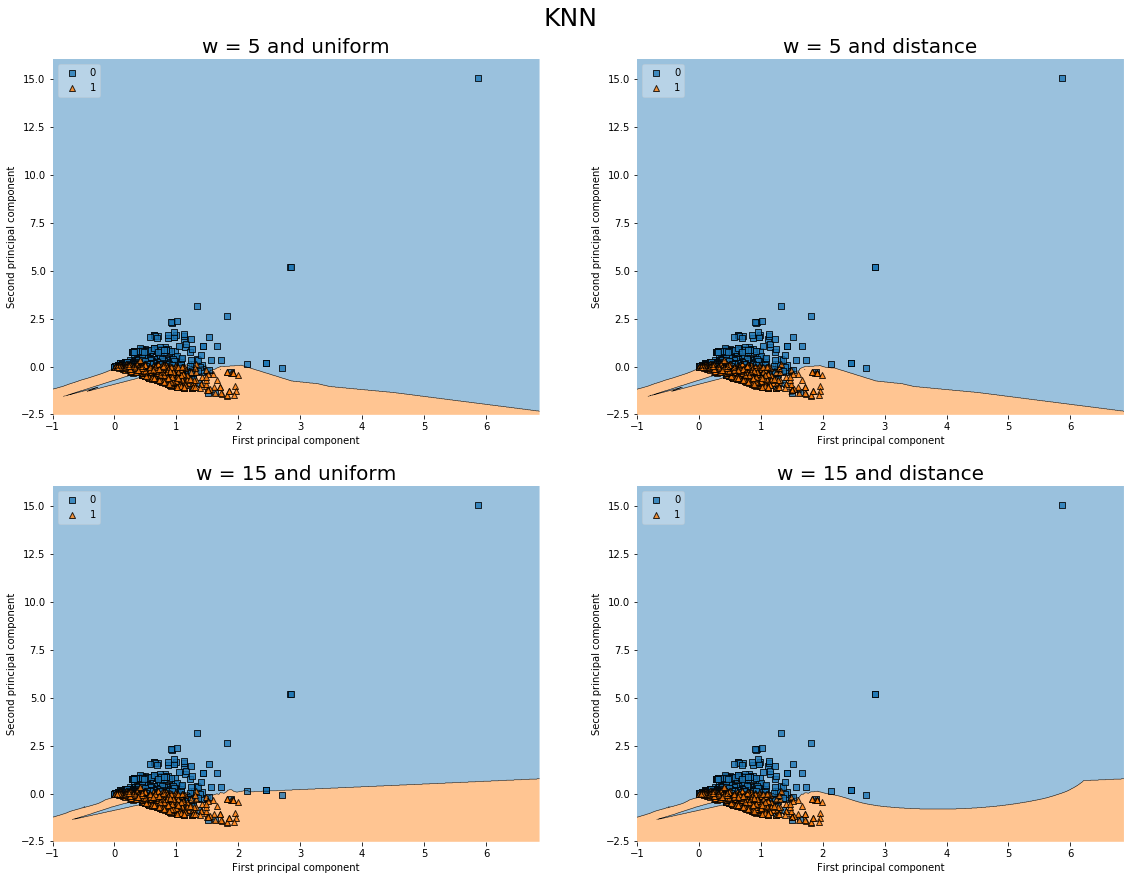

In [84]:
#plot 4 plots of decision regions
fig = plt.figure(figsize = [6.4*3, 4.8*3])

plt.suptitle('KNN', fontsize=25, y = 0.93)

plt.subplot(2, 2, 1)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M13, legend=2)
plt.title('w = 5 and uniform', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 2)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M14, legend=2)
plt.title('w = 5 and distance', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 3)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M15, legend=2)
plt.title('w = 15 and uniform', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.subplot(2, 2, 4)
fig1 = plot_decision_regions(X_tr_reduced, np.array(y_tr)[n], clf=M16, legend=2)
plt.title('w = 15 and distance', fontsize=20)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()
fig.savefig('pca_KNN.png')